<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LicrimoVor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [4]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
sentences: list[tuple[str, int]] = []
words = Counter()
word_threshold = 32


for key in [1, 3]:
    for feature in tqdm(dataset['train']):
        for sentence in sent_tokenize(feature['text']):
            sentence_words = word_tokenize(sentence)
            if len(sentence_words) > word_threshold:
                continue

            match key:
                case 1:
                    for sentence_word in sentence_words:
                        words[sentence_word] += 1
                case 2:
                    words += Counter(sentence_words)
                case 3:
                    words.update(sentence_words)
            sentences.append(sentence)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
print("Всего предложений:", len(sentences))

Всего предложений: 402114


Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [8]:
words.most_common(20)

[('.', 344276),
 ('the', 262170),
 (',', 235892),
 ('a', 147904),
 ('and', 141771),
 ('of', 128861),
 ('to', 123080),
 ('is', 115270),
 ('I', 96658),
 ('it', 81381),
 ('in', 79190),
 ('this', 66986),
 ('that', 64556),
 ("'s", 59486),
 ('was', 56437),
 ('The', 50373),
 ('movie', 49947),
 ('for', 40529),
 ('film', 39301),
 ('/', 39159)]

In [9]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
vocab |= set([word[0] for word in words.most_common(vocab_size)])

In [10]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [11]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [12]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [13]:
class WordDataset(Dataset):
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id, ]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence.append(self.eos_id)
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [14]:
from typing import TypedDict

class BatchType(TypedDict):
    input_ids: torch.LongTensor
    target_ids: torch.LongTensor


def collate_fn_with_padding(
    input_batch: List[List[int]],
    pad_id=word2ind['<pad>']
) -> BatchType:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(DEVICE)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [15]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 256

train_dataloader = DataLoader[BatchType](
    train_dataset,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size
)

eval_dataloader = DataLoader[BatchType](
    eval_dataset,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size
)

test_dataloader = DataLoader[BatchType](
    test_dataset,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size
)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [16]:
def evaluate(model: nn.Module, criterion, dataloader: DataLoader[BatchType]) -> float:
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(0, 1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [17]:
def generate_sequence(model, starting_seq: str, max_seq_len: int=64) -> str:
  """Генерирует строку"""
  model = model.to(DEVICE)
  input_ids = [word2ind["<bos>"]] + [word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
  input_ids = torch.LongTensor(input_ids).to(DEVICE)
  model.eval()
  with torch.no_grad():
    for i in range(max_seq_len):
      next_char_distribution = model(input_ids)[-1]
      next_char = next_char_distribution.squeeze().argmax()
      input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])
      if next_char.item() == word2ind['<eos>']:
        break
  words = ' '.join([ind2word[idx.item()] for idx in input_ids])
  return words

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [18]:
from torch.optim import Optimizer

EPOCHS = 5
METRIC_COUNT = 5
TRAIN_COUNT = len(train_dataloader)
METRIC_STEP = TRAIN_COUNT // METRIC_COUNT

class History(TypedDict):
	train: list[float]
	eval: list[float]
	epoch: list[float]


def train(model: nn.Module, optimizer: Optimizer) -> History:
	"""Алгоритм обучения модели."""
	model.to(DEVICE)
	criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
	history: History = {'eval': [], 'train': [], 'epoch': []}
	for epoch in tqdm(range(EPOCHS)):
		losses = []
		model.train()
		for i, batch in enumerate[BatchType](train_dataloader):
			optimizer.zero_grad()
			logits = model(batch['input_ids']).flatten(0, 1)
			loss = criterion(logits, batch['target_ids'].flatten())
			loss.backward()
			optimizer.step()
			losses.append(loss.item())

			if (i+1) % METRIC_STEP == 0:
				model.eval()
				acc = evaluate(model, criterion, eval_dataloader)
				model.train()
				history['eval'].append(acc)
				history['train'].append(sum(losses) / len(losses))
				history['epoch'].append(epoch + (i // METRIC_STEP + 1) / METRIC_COUNT)
				losses = []

	return history

### Первый и второй эксперименты (4 балла)

Определите архитектуру модели и обучите её.

In [19]:
from typing import Literal, Union


class LanguageSettings(TypedDict):
    """Параметры языковой модели."""
    input_size=int
    hidden_size=int
    output_size=int
    rnn_mode=Literal['rnn', 'lstm', 'gru']
    rnn_num_layers=int
    fc_num_layers=int
    fc_norm=Union[type[nn.Dropout], type[nn.BatchNorm1d], type[nn.LayerNorm]]
    fc_act=Union[type[nn.Tanh], type[nn.Sigmoid], type[nn.ReLU]]


class LanguageModel(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
		    rnn_mode: Literal['rnn', 'lstm', 'gru']='rnn',
        rnn_num_layers: int=1,
        fc_num_layers: int=1,
        fc_norm: Union[type[nn.Dropout], type[nn.BatchNorm1d], type[nn.LayerNorm]]=nn.Dropout,
        fc_act: Union[type[nn.Tanh], type[nn.Sigmoid], type[nn.ReLU]]=nn.Tanh
	  ):
        super().__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        rnn_settings = {'input_size': hidden_size, 'hidden_size': hidden_size, 'num_layers': rnn_num_layers, 'batch_first': True}
        match rnn_mode:
            case 'rnn':
                self.rnn = nn.RNN(**rnn_settings)
            case 'lstm':
                self.rnn = nn.LSTM(**rnn_settings)
            case 'gru':
                self.rnn = nn.GRU(**rnn_settings)

        fc_block = lambda: nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            fc_norm(),
            fc_act(),
		    )
        self.fc_layers = nn.Sequential(
            fc_act(),
            *[fc_block() for _ in range(fc_num_layers)],
            nn.Linear(hidden_size, output_size)
		    )

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embedding = self.embedding(input_batch)
        output, _ = self.rnn(embedding)
        output = self.fc_layers(output)
        return output

In [20]:
from typing import Callable

from torch.optim import Optimizer, Adam, SGD, RMSprop


DEFAULT_SETTINGS: LanguageSettings = {
  	'input_size': len(vocab),
	'hidden_size': 256,
	'output_size': len(vocab),
	'rnn_mode': 'rnn',
	'rnn_num_layers': 1,
	'fc_num_layers': 2,
	'fc_norm': nn.Dropout,
	'fc_act': nn.Tanh,
}
LEARNING_RATE = 1e-4
START_SEQ = 'I am'


class Experiment:
	"""Эксперимент - инкапсулирует данные по 1 серии изменений параметров модели."""

	def __init__(
			self,
			changes: list[LanguageSettings],
			optimizer: Union[type[Optimizer], list[type[Optimizer]]],
			name: str,
		) -> None:
		self.name = name
		self.changes = changes
		self.metrics: list[float] = [None] * len(changes)
		self.results: list[History] = [None] * len(changes)
		self.models: list[LanguageSettings] = [None] * len(changes)
		self.sequences: list[str] = [None] * len(changes)
		self.__opt_list = isinstance(optimizer, list)
		self.__optimizer = optimizer
		if self.__opt_list and len(self.__optimizer) != len(changes):
			raise Exception('len(self.__optimizer) != len(changes)')


	def run(self, train: Callable[[LanguageModel, Optimizer], History]):
		print(f"Run experiment: {self.name}")

		for i in range(len(self.changes)):
			change = self.changes[i]
			settings = {**DEFAULT_SETTINGS, **change}
			model = LanguageModel(**settings)
			if self.__opt_list:
				optimizer = self.__optimizer[i](model.parameters(), LEARNING_RATE)
			else:
				optimizer = self.__optimizer(model.parameters(), LEARNING_RATE)
			history = train(model, optimizer)
			self.models[i] = model
			self.results[i] = history
			self.sequences[i] = generate_sequence(model, START_SEQ)

experiments = [
	Experiment([{}], Adam, 'default'),
	Experiment([
		{'rnn_mode': 'lstm'},
		{'rnn_mode': 'gru'},
	], Adam, 'rnn type'),
	Experiment([
		{},
		{},
	], [SGD, RMSprop], 'optimizer type'),
]

In [ ]:
for experiment in experiments:
    experiment.run(train)

In [23]:
experiments[-1].run(train)

Run experiment: optimizer type


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

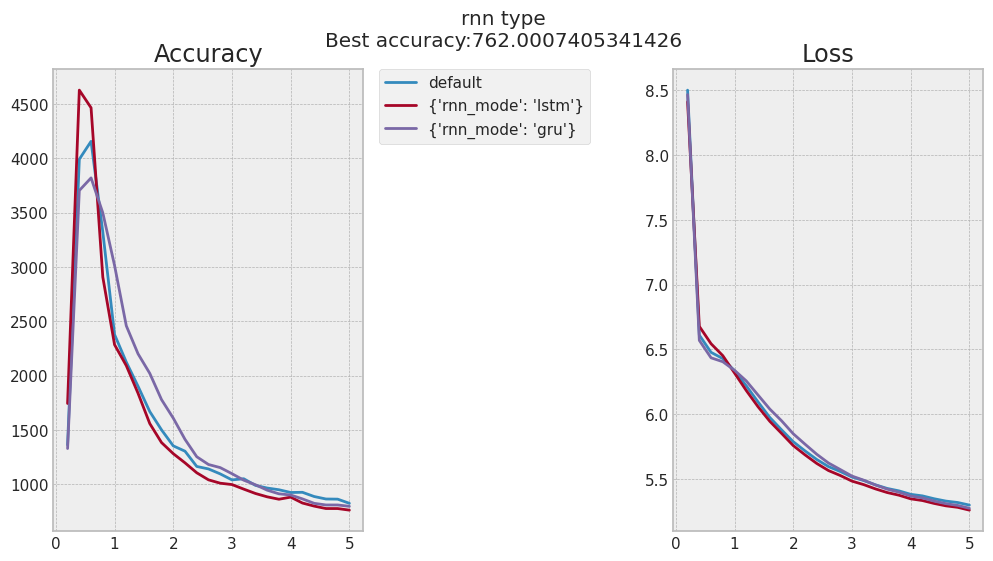

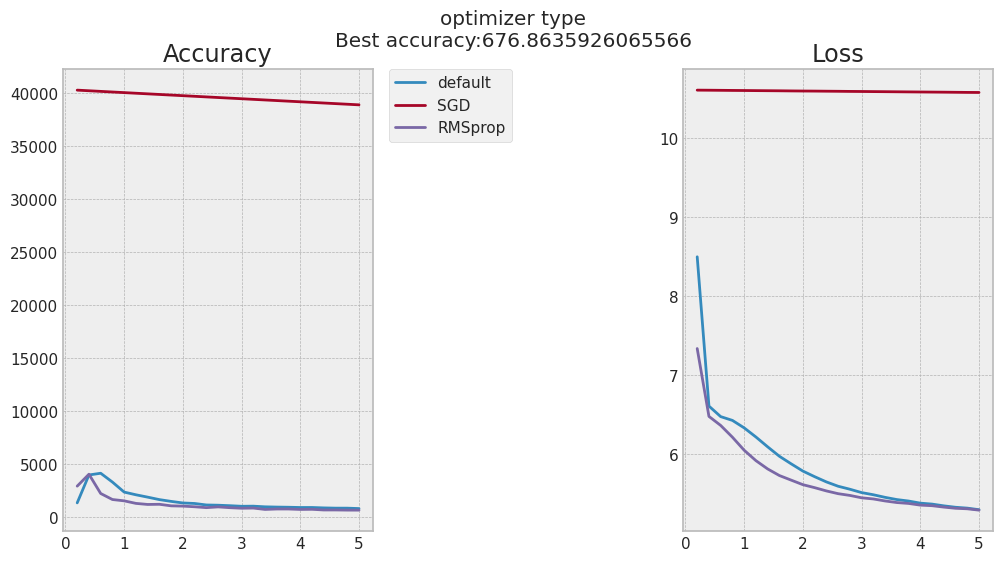

In [44]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

plt.style.use('bmh')

default = experiments[0]
metrics = {}
metrics[default.name] = evaluate(default.models[0], nn.CrossEntropyLoss(ignore_index=word2ind['<pad>']), test_dataloader)
sequences = {}
sequences[default.name] = default.sequences[0]

for experiment in experiments[1:]:
	axs: list[list[Axes]]
	fig, axs = plt.subplots(1, 2)

	fig.set_figwidth(12)
	fig.set_figheight(6)
	fig.subplots_adjust(wspace=1, hspace=0.5)

	# titles
	axs[0].set_title('Accuracy')
	axs[1].set_title('Loss')

	best_acc = 100_000
	# default
	loss = default.results[0]['train']
	acc = default.results[0]['eval']
	epoch = default.results[0]['epoch']
	axs[0].plot(epoch, acc, label='default')
	axs[1].plot(epoch, loss, label='default')

  # experiment
	for j, change in enumerate(experiment.changes):
		loss = experiment.results[j]['train']
		acc = experiment.results[j]['eval']
		epoch = experiment.results[j]['epoch']
		best_acc = min([*acc, best_acc])
		axs[0].plot(epoch, acc, label=str(change))
		axs[1].plot(epoch, loss, label=str(change))
		metrics[f"{experiment.name}_{j}"] = evaluate(experiment.models[j], nn.CrossEntropyLoss(ignore_index=word2ind['<pad>']), test_dataloader)
		sequences[f"{experiment.name}_{j}"] = experiment.sequences[j]

	axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
	fig.suptitle(f'{experiment.name}\nBest accuracy:{best_acc}')
	fig.show()

In [45]:
metrics

{'default': 834.008192617682,
 'rnn type_0': 752.7017687061165,
 'rnn type_1': 781.1636499332476,
 'optimizer type_0': 38877.06200553798,
 'optimizer type_1': 727.699843008307}

In [46]:
sequences

{'default': '<bos> I am a good movie . <eos>',
 'rnn type_0': '<bos> I am a good movie . <eos>',
 'rnn type_1': '<bos> I am a good movie , but it is a good movie . <eos>',
 'optimizer type_0': '<bos> I am announcing jokers Eleanor Mary-Louise fall Niles guts indulging TCM Seduction disguise bodies scoff automotive culprits Remar savor corporation instigated nickname viruses Terence Bloodrayne Iranian sidewalk Convent OR girl Contain categorization Fry Browning 20 4TH generational plot-wise Gradually RIDE gospel groans laconic one-off sickening furnishings NOPE Elke neglect wiggling Golly divorcée advance namesake electrocution plod exploit slipper Find Sciorra Legally Centre visor Stubby mop ranchers',
 'optimizer type_1': '<bos> I am a good movie . <eos>'}

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

-----

1. LSTM показала себя лучше, чем все остальные rnn архитекутры. При тех же параметрах и количестве эпох, она достигает лучшего результата.
2. SGD очень плохо обучает модель. RMSprop показал лучше результат, чем Adam.

Самая лучшая преплексия - 727,7 на тестовой выборке, со словами: `<bos> I am a good movie . <eos>`

P.s. изначально хотел сделать много экспериментов, но ресурсы не позволили(


----